In [27]:
import numpy as np
import xgboost as xgb
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

#from sklearn.preprocessing import CategoricalEncoder
#CategoricalEncoder is part of sklearn's developer version, which you can't just update with conda. If you have issues
#getting this version, try a hard code implementation of the library here - https://pastebin.com/qs1es9XE

In [14]:
df_store = pd.HDFStore('combined_day1.h5')
df = df_store['df']


In [15]:
df.shape

(2262922, 75)

In [16]:

feature_map = []

In [18]:
def transform_column(df, col, thresh=200):
    if col in numerical_features:
        print("Numerical" , col)
        feature_map.append(col)
        return df[col].values.reshape(-1,1)
    
    print(col, df[col].nunique())
    
        
    
    

    
    if df[col].nunique() > thresh:
        df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
        cat = [sorted(df_frequency[0:thresh].index.values)]
        dict2 = {}
        for i, item in enumerate(cat[0]):
            feature_map.append(col + " - " + str(item))
            dict2[item] = i
        #enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
    else:
        dict2 = {}
        i = 0
        for item in df[col].values:
            if item not in dict2:
                feature_map.append(col + " - " + str(item))
                dict2[item] = i
                i+=1
        #enc = CategoricalEncoder(categories='auto',handle_unknown='ignore')
    return [[1 if j == i else 0 for j in dict2] for i in df[col].values]

Our dataset appears to consist of two types of samples - bid samples, and ad samples. Since we are only trying to predict clicks on the ad, AKA "c_cnt", which only exists in ad samples, we will only be working with those data. Let's first parse the data and get what we need.

Parsing data from 12 hours.

In [19]:
#df = pd.read_json("ckh1.json" , lines  = True)

Create a copy of the table as backup (in case original data gets corrupted)

df = pd.read_json("day.json", lines=True)



In [20]:
df.shape

(2262922, 75)

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than some threshhold of non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [21]:
#how many non-nan values do we have?
print(df.count())
n = len(df)

#filter rows with c_cnt as NaN
df = df[np.isfinite(df['c_cnt'])]

#filter threshhold
df = df.dropna(thresh=int(0.5*n), axis=1)
#drop all samples with NaN values
df = df.dropna(axis=0)

_host                    2262922
ad_network_id            2262922
ad_type                  2262922
adlog_count              2262922
advertiser_id            2262922
bid_requests             2262922
bid_responses            2262922
c_cnt                    1724754
c_flag_cnt               1724754
c_timestamp                 1186
c_txn_fee                    429
c_txn_rate                   429
campaign_id              2262922
campaign_type            2262922
ck                       2262922
cr_cnt                   2262922
creative_id              2262922
exp_mode                  475358
f_cnt                    1724754
f_nfr                          2
f_timestamp                    2
flag                       22239
geo_area_code            1788769
geo_city_code            2182133
geo_city_name            2183499
geo_continent_code       2262921
geo_country_code2        2262921
geo_country_code3        2262921
geo_dma_code             1788139
geo_postal_code          2095169
          

Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [22]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
    df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_min)
    df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_min)
    


#final preprocessing
preprocess(df)
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt'])
#we create a copy so that X will not include 'c_cnt'
df2 = df.copy()
df2.drop('c_cnt',inplace=True,axis=1)
#u,s,v = np.linalg.svd(X)

#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200, return_labels=False):
    print(col)
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

Create our X and Y matrices - adjust threshhold values for 1HE here

In [23]:
one_hot_thresh = 20
Y = df['c_cnt'].values

X = np.hstack([transform_column(df, col, thresh=one_hot_thresh) for col in df2])

#X = np.hstack([transform_column(df, col, thresh=one_hot_thresh) if col not in numerical_features else df[col].values.reshape(-1,1)
               #for col in df2])

_host 46
ad_network_id 16
ad_type 2
advertiser_id 23
c_flag_cnt 3
campaign_id 44
campaign_type 2
ck 5
creative_id 100
f_cnt 2
geo_area_code 256
geo_city_code 11444
geo_city_name 8139
geo_dma_code 210
geo_postal_code 16860
geo_region_name 51
geo_timezone 8
Numerical i_cnt
i_flag_cnt 4
i_timestamp 11
ip_address 260620
num_ads 6
pub_network_id 3
Numerical r_cnt
r_num_ads_requested 6
r_num_ads_returned 8
r_timestamp 13
rate_metric 2
referer 74092
session_id 927350
token 100
ua 12237
ua_device 1724
ua_device_type 4
ua_major 72
ua_minor 31
ua_name 35
ua_os 65
ua_os_name 8
url 90728
user_agent 12217
uuid 475380
Numerical vi_cnt
vi_flag_cnt 3
zone_id 51


In [43]:
X_train.shape

(664017, 589)

Now we split the data into 2 sets: training and testing to avoid overfitting of the model. This is done before any subsampling to avoid contaminating the test set. The train set is now subsampled to increase ratio of clicks to nonclicks from 1:2000 to 1:3 which allows models to more accurately learn the click patterns

In [29]:
def fix_class_imbalance_with_subsampling(tempX, tempY, pos_ratio=2):
    tempY = tempY.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(tempY):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([tempX[ind_1],tempX[to_sample_0]])
    Y2 = np.vstack([tempY[ind_1],tempY[to_sample_0]])
    tempY = tempY.reshape(-1)
    
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]

In [11]:


X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)

X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=45)
Y_fix=Y_fix.ravel()


In [20]:
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
pos_weight

2533.4160305343512

Custom training score for various paramters - Inverse of Euclidian Distance: Rewards both higher and less "extreme" values. Uses Precision of training as X and Recall as Y. 

In [13]:
def score(y_pred , y_test):
    test = confusion_matrix(y_test , y_pred)
    prec = test[1][1] / (test[1][1] + test[0][1])
    rec = test[1][1] / (test[1][1] + test[1][0])
    print("Precision: ", prec)
    print("Recall" , rec)
    return ((prec ** 0.5) * (rec ** 0.5))**2

In [38]:
model = xgb.XGBClassifier()

model.fit(X_fix ,Y_fix )

model.predict(X_train)

confusion_mat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
model = xgb.XGBClassifier(objective = "binary:logistic")
model.fit(X_fix ,Y_fix )
y_pred = model.predict(X_test)
#confusion_matrix(y_test,y_pred)
set(y_pred)

{0.0, 1.0}

In [44]:
y_pred = model.predict(X_test)
fs = f1_score(y_test,y_pred)
fs

0.0046191281395636568

### 

In [16]:

scoresRat = []
for rat in [10,20,30,40,50]:
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=rat)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    scoresRat.append(fs)
    print("Rat", rat , " " , fs)



Rat 2000   0.0854700854701


In [38]:
best_feats = [feature_map[i] for i in np.argsort(mdl.feature_importances_)[-20:]]



In [57]:
list(pd.Series(good_feats).value_counts()[:30].index)

['campaign_id - 21827',
 'vi_cnt',
 'ua_device_type - TAB',
 'c_flag_cnt - 0.0',
 'ad_network_id - 1349',
 'referer - http%3A%2F%2Fwww.breitbart.com%2Fbig-government%2F2018%2F03%2F31%2Fvirgil-conservatives-should-understand-corporate-social-responsibility-is-just-another-name-for-political-power-so-wheres-ours%2F',
 'ua_major - 55.0',
 'campaign_id - 25937',
 'geo_postal_code - 20149',
 'ck - ',
 'ua - Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13G36 Safari/601.1',
 'i_timestamp - 00',
 'ad_network_id - 893',
 'url - http://thehill.com/blogs/blog-briefing-room/news/381148-flynns-son-parkland-student-hoggs-parents-didnt-smack-him',
 'url - http://media.breitbart.com/media/if/newsmax.html',
 'ua_name - Chrome',
 'geo_dma_code - 524.0',
 'geo_region_name - CO',
 'geo_region_name - PA',
 'ck - {"widget_type": ["image"]}',
 '_host - an-prod-ralphie-frontline-goofs.us-east-1',
 'referer - http%3A%2F%2Fwww.breitbart.com%2F',
 'ge

In [53]:
good_feats = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=50)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)

    for w in np.argsort(mdl.feature_importances_)[-20:]:
        good_feats.append(feature_map[w])
        print(feature_map[w])
    print(i, len(good_feats))
        




creative_id - 1814135
geo_region_name - CO
r_timestamp - 04
geo_region_name - PA
geo_region_name - FL
url - https://www.roughlyexplained.com/viral-videos/
ua_name - Mobile Safari
url - http://thehill.com/blogs/blog-briefing-room/news/381148-flynns-son-parkland-student-hoggs-parents-didnt-smack-him
url - http://media.breitbart.com/media/if/newsmax.html
ua_major - 55.0
referer - http%3A%2F%2Fwww.breitbart.com%2Fbig-government%2F2018%2F03%2F31%2Fvirgil-conservatives-should-understand-corporate-social-responsibility-is-just-another-name-for-political-power-so-wheres-ours%2F
ad_network_id - 893
ck - 
ad_network_id - 1349
campaign_id - 21827
ua_device_type - TAB
campaign_id - 25937
geo_postal_code - 20149
c_flag_cnt - 0.0
vi_cnt
0 20
ck - {"widget_type": ["image"]}
r_timestamp - 04
ua_os - iOS 11.2
i_timestamp - 08
ua - Mozilla/5.0 (Linux; Android 8.0.0; SM-G950U Build/R16NW) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.109 Mobile Safari/537.36
campaign_id - 21827
url - http://med

ua_device - Samsung SM-T580
ck - {"widget_type": ["image"]}
geo_timezone - America/New_York
geo_timezone - America/Chicago
_host - an-prod-ralphie-frontline-proxy.us-east-1
geo_region_name - NJ
i_timestamp - 01
zone_id - 18188
referer - http%3A%2F%2Fwww.breitbart.com%2Fbig-government%2F2018%2F03%2F31%2Fvirgil-conservatives-should-understand-corporate-social-responsibility-is-just-another-name-for-political-power-so-wheres-ours%2F
url - http://thehill.com/blogs/blog-briefing-room/news/381148-flynns-son-parkland-student-hoggs-parents-didnt-smack-him
ad_network_id - 1349
ua_major - 55.0
i_timestamp - 00
campaign_id - 21827
campaign_id - 25937
ck - 
c_flag_cnt - 0.0
geo_postal_code - 20149
ua_device_type - TAB
vi_cnt
12 260
geo_dma_code - 524.0
geo_dma_code - 510.0
geo_region_name - FL
ua_device - iPad
ua_os_name - Android
geo_timezone - America/New_York
geo_region_name - IN
ua_major - 55.0
ua_name - Chrome
ua_os - Android 8.0
ua - Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X) AppleWebKit

_host - an-prod-ralphie-frontline-proxy.us-east-1                                                                                                                                                                 1
geo_postal_code - 20149                                                                                                                                                                                           1
ua_device_type - TAB                                                                                                                                                                                              1
ck -                                                                                                                                                                                                              1
campaign_id - 25937                                                                                                                                     

<Container object of 589 artists>

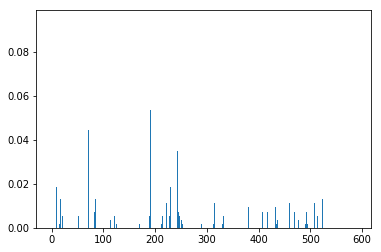

In [57]:
plt.bar(range(len(mdl.feature_importances_)), mdl.feature_importances_)

array([ 0.        ,  0.05360444,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

In [52]:
avgScores = []
for i in range(10): 
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=45)
    Y_fix=Y_fix.ravel()
    mdl = xgb.XGBClassifier()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    s = f1_score(y_test,y_pred)
    print(i , s)
    avgScores.append(s)
avgScores











0 0.106382978723
1 0.139240506329
2 0.121546961326
3 0.0939597315436
4 0.0677966101695
5 0.220930232558
6 0.0952380952381
7 0.105263157895
8 0.133333333333
9 0.10152284264


[0.10638297872340426,
 0.13924050632911394,
 0.12154696132596685,
 0.093959731543624164,
 0.067796610169491525,
 0.22093023255813954,
 0.095238095238095233,
 0.10526315789473685,
 0.13333333333333333,
 0.10152284263959389]

In [53]:
sum(avgScores) / len(avgScores)

0.11852144497554998

Run PCA to condense the data to 80% of it's variance, but cut the featuers from 350 -> 30. This allows it to train faster later

In [47]:
pca = PCA(n_components = 0.8)
pca.fit(X_train)
X_train_small = pca.transform(X_train)
X_test_small = pca.transform(X_test)

Run a search across all possible paramters for RF in order to find one that maximizes score.

In [34]:


scores = []

for g in [0]:
    n_s = []
    for n_est in range(1):
        mdl = xgb.XGBClassifier(gamma = 0 , max_depth = 3)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        n_s.append(fs)
        print("Score for gamma: " , g , " depth: " , n_est)
        score(y_pred , y_test)
    scores.append(n_s)












Score for gamma:  0  depth:  0
Precision:  0.00206832608231
Recall 0.456692913386


Plot the number of estimators (1,10 ,50 ,100) on the x-axis vs number of maximum number of features in a given tree (sqrt , lg2 , 10 , 30 , 50) : y-axis, in a heat map format to see which features provide highest accuracy. Use F1 metric to score models

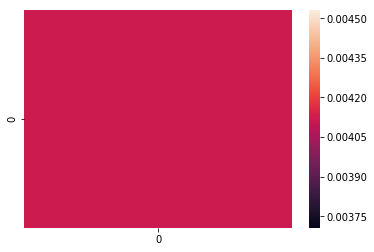

In [35]:
sns.heatmap(scores)

Looks like lg2 features did the most consistently and 50 estimators did the best. So use these for next grid search

Notes for reading confusion matrix

[0][0] correct non-clicked
[1][0] - Incorrect - ACTUALLY CLICK
[0][1] - Inccroect  - ACTUALLY NONCLICK
[1][1] - correct click


Do another grid search on Weighting and Max_depth. Trying to see if weighting the positive class will increase precision from last classifcation.

In [69]:


weight = {0:1 , 1:1}

scores = []

for weights in [0.001 , 0.1, 1,10,100,1000]:
    n_s = []
    for max_depths  in [1 , 10 , 100]:
        weight = {0:1 , 1:weights}
        mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = weight , max_depth= max_depths)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        #print(fs)
        n_s.append(fs)
        score(y_pred , y_test)
       # n_s.append(score(y_pred , y_test))
    scores.append(n_s)












C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0170212765957
Recall 0.0155642023346
Precision:  0.00499873627454
Recall 0.692607003891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0078125
Recall 0.105058365759
Precision:  0.0048440554092
Recall 0.665369649805
Precision:  0.0136612021858
Recall 0.0194552529183
Precision:  0.00740667588386
Recall 0.583657587549
Precision:  0.00485080940831
Recall 0.669260700389
Precision:  0.000596870725233
Recall 1.0
Precision:  0.00222275956996
Recall 0.929961089494
Precision:  0.00487977754757
Recall 0.696498054475
Precision:  0.000596870725233
Recall 1.0
Precision:  0.000604458409969
Recall 1.0
Precision:  0.00504574438592
Recall 0.708171206226
Precision:  0.000596870725233
Recall 1.0
Precision:  0.0006015917603
Recall 1.0
Precision:  0.00497582368155
Recall 0.688715953307


Heat map with weighting for positive class on y  [0.001 , 0.1, 1,10,100,1000] and max depth on X [1 , 10 , 100]. 

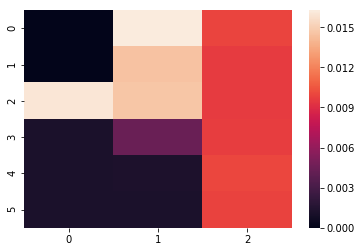

In [70]:
sns.heatmap(scores)

Best performace currently: max_features = "log2", n_estimators = 50 , class_weight: 0:1 , 1:0.001 , max_depth= 10)

In [82]:
mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = {0:1 , 1:1.5} , max_depth= 1)
mdl.fit(X_fix , Y_fix)
y_pred = mdl.predict(X_test)
score(y_pred , y_test)

Precision:  0.00721175516091
Recall 0.311284046693


0.0022449043302450707

Unfortunetly still has very poor performance on all paramters - next going to try seeing if changing the test ratio helps at all.

In [22]:
scores = []
mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = {0:1 , 1:1.5} , max_depth= 50)
for ratios in range(1,50):
    n_s = []
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=ratios)
    Y_fix=Y_fix.ravel()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    n_s.append(fs)
    score(y_pred , y_test)
    scores.append(n_s)



Precision:  0.00241677614456
Recall 0.819327731092
Precision:  0.00376950932848
Recall 0.747899159664
Precision:  0.0047451619358
Recall 0.697478991597
Precision:  0.00528900642236
Recall 0.647058823529
Precision:  0.00621813207313
Recall 0.63025210084
Precision:  0.00687351759524
Recall 0.596638655462
Precision:  0.00710450675199
Recall 0.550420168067
Precision:  0.00734394124847
Recall 0.504201680672
Precision:  0.00839694656489
Recall 0.508403361345
Precision:  0.00845219228737
Recall 0.470588235294
Precision:  0.00878612716763
Recall 0.478991596639
Precision:  0.00930026572188
Recall 0.441176470588
Precision:  0.00878449345937
Recall 0.386554621849
Precision:  0.0098433530906
Recall 0.390756302521
Precision:  0.0106933813597
Recall 0.399159663866
Precision:  0.0108903781714
Recall 0.382352941176
Precision:  0.0109730301428
Recall 0.348739495798
Precision:  0.0107719928187
Recall 0.327731092437
Precision:  0.0107302533532
Recall 0.302521008403
Precision:  0.0113053964426
Recall 0.31

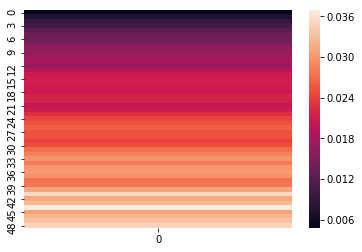

In [23]:
sns.heatmap(scores)

In [24]:
def feature_scoring_random_subsample(lst, df, model, oh_thresh, resample_thresh, p=0.3, iterations=10000):
    transformed_col, past_score = {}, {}
    for col in df.columns:
        if col == 'c_cnt': continue
        if col not in numerical_features:
            transformed_col[col] = transform_column(df, col, thresh=oh_thresh)
    Y = df['c_cnt'].values
    scores = []
    for i in range(iterations):
        print("Iteration: ", i)
        #subsample random columns with probability p
        selected = [c for c in df.columns if random.random() < p and c != 'c_cnt']
        print(selected)
        #if we have no items, super unlucky, try again
        if len(selected) < 1: continue
        X = np.hstack([transformed_col[col] if col not in numerical_features else df[col].values.reshape(-1,1)
                   for col in selected])
        remove_corr_features(X, None)
        X_train, Y_train, X_test, Y_test = test_train_split(X, Y)
        X_train, Y_train = fix_class_imbalance_with_subsampling(X_train, Y_train,pos_ratio=resample_thresh)

        lr = clone(model)
        lr.fit(X_train, Y_train)
        test_cm = confusion_matrix(Y_test, [i for i in lr.predict(X_test)])
        score = get_f1_score(test_cm)
        if math.isnan(score): continue
        scores.append((selected, score))
        
        if i > 0 and i % 100 == 0: #Updates score list every 100 iterations, and checks for convergence
            feature_scores = {}
            for f in df.columns:
                if f == 'c_cnt': continue
                feature_score = []
                for cols, score in scores:
                    if f in cols:
                        feature_score.append(score)
                feature_scores[f] = np.mean(feature_score)
            lst = []
            for feat in feature_scores:
                lst.append((feature_scores[feat], feat))
            lst = sorted(lst)
            lst.reverse()
            #check for convergence
            if i > 100:
                print(lst)
                has_conv = True
                for f in df.columns:
                    if f not in past_score or f not in feature_scores:
                        has_conv = False
                        break
                    if abs(past_score[f]-feature_scores[f])/feature_scores[f] > 0.01: has_conv = False
                if has_conv:
                    return lst
            past_score = feature_scores

In [97]:
scores = []
mdl = RFC(max_features = "log2", n_estimators = 100 , class_weight = {0:1 , 1:1.5} , max_depth= 100)
for ratios in range(1,150 , 10):
    n_s = []
    X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=ratios)
    Y_fix=Y_fix.ravel()
    mdl.fit(X_fix , Y_fix)
    y_pred = mdl.predict(X_test)
    fs = f1_score(y_test,y_pred)
    n_s.append(fs)
    score(y_pred , y_test)
    scores.append(n_s)



Precision:  0.0026712623869
Recall 0.768595041322
Precision:  0.00811568540652
Recall 0.454545454545
Precision:  0.011520335137
Recall 0.272727272727
Precision:  0.0125702059374
Recall 0.194214876033
Precision:  0.0143856920684
Recall 0.152892561983
Precision:  0.0147565174619
Recall 0.123966942149
Precision:  0.019524100061
Recall 0.132231404959
Precision:  0.020749665328
Recall 0.128099173554
Precision:  0.020999275887
Recall 0.119834710744
Precision:  0.0227081581161
Recall 0.111570247934
Precision:  0.0273327049953
Recall 0.119834710744
Precision:  0.0317286652079
Recall 0.119834710744
Precision:  0.0324449594438
Recall 0.115702479339
Precision:  0.0320987654321
Recall 0.107438016529
Precision:  0.0323834196891
Recall 0.103305785124


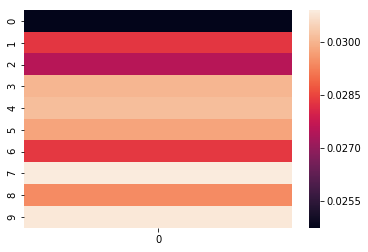